In [1]:

import os, math, time, random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
 
import cv2
from glob import glob
import tensorflow as tf
from sklearn.utils import shuffle

 # skimage
from skimage.io import imread 
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage import data, color

# pil
from PIL import Image as pil_image

import warnings
warnings.filterwarnings("ignore")

# from keras
import keras
from keras.layers import Concatenate, Input
from keras.models import Model
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential
from keras.layers import  MaxPooling2D, BatchNormalization, Flatten
from keras.layers import Input, Conv2D, Activation,  MaxPool2D, AveragePooling2D
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.activations import relu, sigmoid
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.applications.vgg16 import VGG16
from keras.layers import Concatenate
from keras.models import Model
from keras.optimizers import Adam
#from keras.applications.resnet import ResNet101

# scikit learn helper functions
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
import warnings
import threading
from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtWidgets import QTableWidgetItem
from PyQt5.QtWidgets import *
from PyQt5.QtGui import QPixmap
import pandas as pd

In [2]:
"""print(y_pred)"""

'print(y_pred)'

In [3]:
"""y_test = (y_pred.flatten()>0.75).astype('int8')
submission['has_cactus']=y_pred
submission.to_csv("submission.csv",index=False)"""

'y_test = (y_pred.flatten()>0.75).astype(\'int8\')\nsubmission[\'has_cactus\']=y_pred\nsubmission.to_csv("submission.csv",index=False)'

In [4]:
"""

from sklearn.metrics import confusion_matrix
conf = confusion_matrix(X_test, predicted)
confMatrix(cf_matrix=conf,pngName="_karisiklik_matris_test")"""

'\n\nfrom sklearn.metrics import confusion_matrix\nconf = confusion_matrix(X_test, predicted)\nconfMatrix(cf_matrix=conf,pngName="_karisiklik_matris_test")'

In [5]:


def confMatrix(cf_matrix,pngName):
  from sklearn.metrics import confusion_matrix
  import sklearn.metrics as mt
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
  ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');
  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])
  plt.legend()
  ## Display the visualization of the Confusion Matrix.
  plt.savefig(pngName+'.png', dpi=300, bbox_inches='tight')
  plt.show()

In [6]:
# retunrs a complete path to a image with Image name
def expand_path(path):
    if os.path.isfile('train/train/' + path):
        return 'train/train/' + path
    if os.path.isfile('test/test/' + path):
        return 'test/test/' + path
    return path

# returns a resized black and white PIL Image object
def pil_image_load(image):
    image_path = expand_path(image)
    image = pil_image.open(image_path)#.convert('L')
    return image.resize((32, 32))
    #return image
    
# load the resized image
def read_image(img_path, resized_shape=None):
    # expanding img_path to complete image path
    img_path = expand_path(img_path)
    image = imread(img_path)
    gray_image = color.rgb2gray(image)
    rgb_image = color.gray2rgb(gray_image)
    if resized_shape:
        image_resized = resize(rgb_image,(resized_shape,resized_shape, 3))
        return image_resized[:,:]/255
    return rgb_image[:,:]/255
# returns a batch of image for training
def train_batch(train_df):
    batch_size = train_df.shape[0]
    images = train_df.image.values
    first_image = images[0]
    x_train = []
    y_train = train_df.has_cactus.values
    for i, image in enumerate(images):
        x_train.append(image.tolist())
    x_train = np.array(x_train)
    y_train = y_train.reshape(len(y_train), 1)
    return x_train, y_train


class CustomCNN(tf.keras.Sequential):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = Conv2D(128, (3, 3), strides=(1, 1), input_shape=(32, 32, 3))
        self.batchnorm1 = BatchNormalization()
        self.act1 = Activation('relu')
        self.pool1 = MaxPooling2D((2, 2))

        self.conv2 = Conv2D(256, (3, 3), strides=(1, 1))
        self.batchnorm2 = BatchNormalization()
        self.act2 = Activation('relu')
        self.pool2 = MaxPooling2D((2, 2))

        self.conv3 = Conv2D(128, (3, 3), strides=(1, 1))
        self.batchnorm3 = BatchNormalization()
        self.act3 = Activation('relu')
        self.pool3 = MaxPooling2D((2, 2))

        self.flatten = Flatten()
        self.dense1 = Dense(512, activation='relu')
        self.dropout1 = Dropout(0.5)
        self.dense2 = Dense(256, activation='relu')
        self.dropout2 = Dropout(0.25)
        self.dense3 = Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.batchnorm1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.act3(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        x = self.dense3(x)

        return x
    def build(self,input_shape):
        self.built=True





# CNN model
def CNN():
    model = Sequential()
    model.add(Conv2D(128, (3, 3), strides = (1, 1), input_shape = (32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(256, (3, 3), strides = (1,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), strides = (1,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # fully connected layer
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))
    
    # output
    model.add(Dense(1, activation='sigmoid'))
    
    # compiling
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# Ref: https://www.kaggle.com/CVxTz/cnn-starter-nasnet-mobile-0-9709-lb
def NASNetMoibleClassifier():
    inputs = Input((32, 32, 3))
    base_model = NASNetMobile(include_top=False, input_shape=(32, 32, 3))#, weights=None
    x = base_model(inputs)
    
    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    out3 = Flatten()(x)
    
    out = Concatenate(axis=-1)([out1, out2, out3])
    out = Dropout(0.5)(out)
    out = Dense(1, activation="softmax")(out)
    
    model = Model(inputs, out)
    model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['acc'])
    model.summary()
    return model
# Ref: https://www.kaggle.com/CVxTz/cnn-starter-nasnet-mobile-0-9709-lb
def VGGModel():
    model_vg = VGG16(weights='imagenet',include_top=False, input_shape=(32, 32, 3))
    #model_vg.trainable = False
    
    model = Sequential()
    model.add(model_vg)
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model
def train_model(model, X_train, y_train,pngName,accuracyName='accuracy', epochs=5, verbose=None):
    begin = time.time()
    # checkpoint
    checkpointer = ModelCheckpoint(filepath='weights.hdf5', monitor='val_'+accuracyName, verbose=0, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)
    modelHistory=[]
    modelLoss=[]
    modelAcc=[]
    modelValAcc=[]
    modelValLoss=[]
    for i in range(1, epochs + 1):
        #print('************************************')
        #print('Epoch: ', i, '/', epochs)
        #print('************************************')
        if verbose:
            verbose = verbose
        # fitting
        model.fit(X_train, y_train, verbose=verbose, callbacks=[checkpointer, early_stopping], validation_split=0.1, shuffle=True)
        print(model.history.history)
        modelLoss.append(model.history.history['loss'])
        modelAcc.append(model.history.history[accuracyName])
        modelValAcc.append(model.history.history['val_'+accuracyName])
        modelValLoss.append(model.history.history['val_loss'])

        
        # plot the loss values


    # done!
    plt.plot(modelAcc)
    plt.plot(modelValAcc)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(pngName+'valacc.png', dpi=300, bbox_inches='tight')
    plt.show()
    # plot the accuracy values
    plt.plot(modelAcc)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy values')
    plt.legend()
    plt.savefig(pngName+'accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()

    # plot the accuracy values
    plt.plot(modelLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss values')
    plt.legend()
    plt.savefig(pngName+'loss.png', dpi=300, bbox_inches='tight')
    plt.show()
    # plot the Vall Losss values
    plt.plot(modelLoss)
    plt.plot(modelValLoss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(pngName+'valloss.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("CNN/")
   # print(conf)

    
    
    
    elapsed = time.time() - begin
    print('total training time: ', elapsed)
    return model


def benimModel():
    model = CustomCNN()
    model.build(input_shape=(32, 32, 3))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [7]:

def start(threadname,epochs_size_n,batch_size,validation_split_size,kfold_n,holdout_n,random_state_n,selected_cb,test_size_n):
    selectedModelText=""
    IMG_SIZE = 32 # in the given original size
    print('Given files: ', os.listdir('../'))
    # data shapes
    print('train images: ', len(os.listdir('train/train')))
    print('test images: ', len(os.listdir('test/test')))
    
    from keras.preprocessing.image import ImageDataGenerator



    # folders
    train_folder = 'train/train'
    test_folder = 'test/test'
    train_df = pd.read_csv('train.csv')
    train_images_path = glob('train/train/*.jpg')
    test_images_path = glob('test/test/*.jpg')

    # train data dataframe
    train_df['image'] = train_df['id'].apply(lambda path: read_image(path))

    # creating test dataframe
    test_df = pd.DataFrame(columns=["id", "image"])
    test_df['id'] = os.listdir('test/test/')
    test_df['image'] = test_df['id'].apply(lambda path: read_image(path))
    
    # some visualizations 
    random.shuffle(train_images_path)
    fig, ax = plt.subplots(2,5, figsize=(15,6))
    fig.suptitle('Some aerial images',fontsize=16)

    df = shuffle(train_df)
    for i, item in enumerate(df.values[15:20]):
        image = pil_image.open(expand_path(item[0]))
        ax[0,i].imshow(image)
        ax[0, i].set_title('Has Cactus = %d' % (item[1]))
    ax[0,0].set_ylabel('train images', size='large')

    for i, path in enumerate(test_images_path[:5]):
        image = pil_image.open(path)
        #image = image.resize((IMG_SIZE, IMG_SIZE))
        ax[1,i].imshow(image)
    ax[1,0].set_ylabel('test images', size='large');
    plt.legend()
    ## Display the visualization of the Confusion Matrix.
    plt.savefig('images/testandtrain'+'.png', dpi=300, bbox_inches='tight')
    plt.show()
    # training data
    X_train, y_train = train_batch(train_df)


    print(len(X_train))
    print(len(y_train))
        # batch train (with batch load) the model with training data

    
    epoch_sz=2
    fileName=""
    model=CNN()
    batch_sz=64
    selected_cb=1
    if (selected_cb==1):
        fileName=""
    if (selected_cb==2):
        fileName=""
    if (selected_cb==3):
        fileName=""
    if (selected_cb==4):
        fileName=""
    # training
    from sklearn.model_selection import KFold
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score, f1_score
    kf = KFold(n_splits=2)
    x=X_train
    y=y_train
    accuracies = []
    confs = []
    accs = []
    index=1

    for train_index, test_index in kf.split(x):
            x_train, x_test = x[train_index], x[test_index]
            Y_train, Y_test = y[train_index], y[test_index]

            if (selected_cb==1):
                model=CNN()
                model.summary()
                md1 = train_model(model, x_train, Y_train,'CNN/', epochs=epochs_size_n, verbose=1)
               #  create lists for the loss and accuracy values        
                predicted = md1.predict(x_test)
                conf = confusion_matrix(Y_test, predicted)
                confMatrix(cf_matrix=conf,pngName="CNN/"+"_karisiklik_matris"+str(index))
                md1.save('CNN/model.h5')
                v
            if (selected_cb==2):
                model=VGGModel()
                model.summary()
                md1 = train_model(model, x_train, Y_train,'VGGModel/', epochs=epochs_size_n, verbose=1)
                predicted = md1.predict(x_test).astype("int")
                conf = confusion_matrix(Y_test, predicted)
                confMatrix(cf_matrix=conf,pngName="VGGModel/"+"_karisiklik_matris"+str(index))
                md1.save('VGGModel/model.h5') 

            if (selected_cb==3):        
                model=NASNetMoibleClassifier()
                model.summary()
                md1 = train_model(model, x_train, Y_train,'NASNetMoibleClassifier/','acc', epochs=epochs_size_n, verbose=1)
                predicted = md1.predict(x_test).astype("int")
                conf = confusion_matrix(Y_test, predicted)
                confMatrix(cf_matrix=conf,pngName="NASNetMoibleClassifier/"+"_karisiklik_matris"+str(index))
                md1.save('NASNetMoibleClassifier/model.h5')

            if (selected_cb==4):
                model=benimModel()
                model.summary()
                md1 = train_model(model, x_train, Y_train,'benim/', epochs=epochs_size_n, verbose=1)
                predicted = md1.predict(x_test>0.5).astype("int")
                conf = confusion_matrix(Y_test, predicted)
                confMatrix(cf_matrix=conf,pngName="benim/"+"_karisiklik_matris"+str(index))
                md1.save('benim/model.h5')
            if (selected_cb==5):  
                #veri augmantation veri çoklama 
                datagen = ImageDataGenerator(
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest')
                X_train, y_train = train_batch(train_df)
                datagen.fit(X_train)
                model=benimModel()
                ##md1 = train_model(model, x_train, Y_train,'CNN/', epochs=epochs_size_n, verbose=1)
                md1=model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                steps_per_epoch=len(X_train) / 32, epochs=epoch_size_n)
                md1.save('dataaugmantation/model.h5')




            index+=1
        

In [8]:


    




class Ui_MainWindow(object):
    cnnImages=[]
    cnnIndex=0
    nasnetImages=[]
    nasnetIndex=0
    vggmodelImages=[]
    vggmodelIndex=0
    imagesImages=[]
    imagesIndex=0
    benimIndex=0
    benimImages=[]
    
    
    def clicked_btn_start(self):

        epoch=int(self.epoch_tx.text())
        batch=int(self.batch_tx.text())
        validation=float(self.validation_split_tx.text())
        kfold=int(self.kfold_tx.text())
        holdout=int(self.hold_out_tx.text())
        randomstate=int(self.random_state_tx.text())
        model=int(self.baslat_model_sec_cb.currentIndex())
        test=float(self.test_size_tx.text())
       
        t1 = threading.Thread(target=start, args=("thread-1", epoch,batch,validation,kfold,holdout,randomstate,model,test))
        
        t1.start()
        msg = QMessageBox()
        msg.setText('İşlem Başladı.')
        msg.setStandardButtons(QMessageBox.Ok | QMessageBox.Cancel)
        result = msg.exec_()
        
        
    def getData(self,index):
        if (index==-1):
          return self.imagesImages,self.imagesIndex,self.gorsel_next,self.gorsel_prev ,self.label
        if (index==0):
          return self.cnnImages,self.cnnIndex,self.gorsel_next_2,self.gorsel_prev_2 ,self.label_2
        if (index==1):
          return self.vggmodelImages,self.vggmodelIndex,self.gorsel_next_3,self.gorsel_prev_3,self.label_3
        if (index==2):
          return self.nasnetImages,self.nasnetIndex,self.gorsel_next_4,self.gorsel_prev_4 ,self.label_4
        if (index==3):
          return self.benimImages,self.benimIndex,self.gorsel_next_5,self.gorsel_prev_5,self.label_5



    def clicked_btn_next(self,index,location):
        dt=self.getData(index)
        if dt[1] != len(dt[0]) - 1:
            if (index==-1):
               self.imagesIndex+=1
            if (index==0):
               self.cnnIndex+=1
            if (index==1):
               self.vggmodelIndex +=1
            if (index==2):
               self.nasnetIndex +=1
            if (index==3):
               self.benimIndex +=1
            dt[3].setEnabled(True)
        else:
            dt[2].setEnabled(False)
        dt=self.getData(index)
        dt[3].setEnabled(True)
        dt[4].setPixmap(QtGui.QPixmap(location+"/"+dt[0][dt[1]]))

    def clicked_btn_prev(self,index,location):
        dt=self.getData(index)
        if dt[1] != 0:
            if (index==-1):
               self.imagesIndex-=1
            if (index==0):
               self.cnnIndex-=1
            if (index==1):
               self.vggmodelIndex -=1
            if (index==2):
               self.nasnetIndex -=1
            if (index==3):
               self.benimIndex -=1
            dt[2].setEnabled(True)
        else:
            dt[3].setEnabled(False)
        dt=self.getData(index)
        dt[2].setEnabled(True)
        dt[4].setPixmap(QtGui.QPixmap(location+"/"+dt[0][dt[1]]))
           
    

    def openFileNameDialog(self):
            IMG_SIZE=32
            print('1')
            options = QFileDialog.Options()
            print('2')
            options |= QFileDialog.ReadOnly
            print('3')
            from PIL import Image
            
            fileName = QFileDialog.getOpenFileName()
            
            if fileName:
                self.model_test_acc_lbl.setPixmap(QtGui.QPixmap(fileName[0]))
              #  self.model_test_acc_lbl.setPixmap(QPixmap(fileName).scaled(self.label.width(), self.label.height(), Qt.KeepAspectRatio))
                model=CNN()
                
                model.load_weights('CNN/model.h5')

                # Preprocessing image
                img = Image.open(fileName[0]).resize((IMG_SIZE, IMG_SIZE))
                img_tensor = np.asarray(img)
                img_tensor = np.expand_dims(img_tensor, axis=0)
                # Get predictions
                predictions = model.predict(img_tensor)
                predicted_class = np.argmax(predictions[0])

                print("The image is predicted to be class: ", predicted_class)
                self.model_test_start_btn.setText( str(predicted_class))



    def testData(self):
        predicted = model.predict(x_test).astype("int")
        print('kfoldddd4')
        print(index,". "," accuracy:",str(accuracy_score(y_test, predicted.round())))        
    def setupUi(self, MainWindow):
        MainWindow.setObjectName("MainWindow")
        MainWindow.resize(1106, 600)
        palette = QtGui.QPalette()
        brush = QtGui.QBrush(QtGui.QColor(170, 255, 255))
        brush.setStyle(QtCore.Qt.SolidPattern)
        palette.setBrush(QtGui.QPalette.Active, QtGui.QPalette.Button, brush)
        brush = QtGui.QBrush(QtGui.QColor(170, 255, 255))
        brush.setStyle(QtCore.Qt.SolidPattern)
        palette.setBrush(QtGui.QPalette.Inactive, QtGui.QPalette.Button, brush)
        brush = QtGui.QBrush(QtGui.QColor(170, 255, 255))
        brush.setStyle(QtCore.Qt.SolidPattern)
        palette.setBrush(QtGui.QPalette.Disabled, QtGui.QPalette.Button, brush)
        MainWindow.setPalette(palette)
        MainWindow.setToolButtonStyle(QtCore.Qt.ToolButtonIconOnly)
        MainWindow.setTabShape(QtWidgets.QTabWidget.Rounded)
        self.centralwidget = QtWidgets.QWidget(MainWindow)
        self.centralwidget.setObjectName("centralwidget")
        self.verticalLayoutWidget = QtWidgets.QWidget(self.centralwidget)
        self.verticalLayoutWidget.setGeometry(QtCore.QRect(10, 0, 1071, 581))
        self.verticalLayoutWidget.setObjectName("verticalLayoutWidget")
        self.verticalLayout = QtWidgets.QVBoxLayout(self.verticalLayoutWidget)
        self.verticalLayout.setContentsMargins(0, 0, 0, 0)
        self.verticalLayout.setObjectName("verticalLayout")
        self.tabWidget = QtWidgets.QTabWidget(self.verticalLayoutWidget)
        self.tabWidget.setTabShape(QtWidgets.QTabWidget.Triangular)
        self.tabWidget.setUsesScrollButtons(True)
        self.tabWidget.setDocumentMode(False)
        self.tabWidget.setTabsClosable(False)
        self.tabWidget.setMovable(True)
        self.tabWidget.setObjectName("tabWidget")
        self.dataset_tp = QtWidgets.QWidget()
        self.dataset_tp.setObjectName("dataset_tp")
        self.train_tw = QtWidgets.QTableWidget(self.dataset_tp)
        self.train_tw.setGeometry(QtCore.QRect(60, 190, 631, 560))
        self.train_tw.setObjectName("train_tw")
        self.train_tw.setColumnCount(0)
        self.train_tw.setRowCount(0)
        self.tabWidget.addTab(self.dataset_tp, "")
        self.charts_tp = QtWidgets.QWidget()
        self.charts_tp.setObjectName("charts_tp")
        self.tabWidget_2 = QtWidgets.QTabWidget(self.charts_tp)
        self.tabWidget_2.setGeometry(QtCore.QRect(50, 40, 951, 451))
        self.tabWidget_2.setCursor(QtGui.QCursor(QtCore.Qt.PointingHandCursor))
        self.tabWidget_2.setMouseTracking(False)
        self.tabWidget_2.setAutoFillBackground(False)
        self.tabWidget_2.setObjectName("tabWidget_2")
        self.tab = QtWidgets.QWidget()
        self.tab.setObjectName("tab")
        self.gorsel_next = QtWidgets.QPushButton(self.tab)
        self.gorsel_next.setGeometry(QtCore.QRect(500, 390, 105, 23))
        self.gorsel_next.setObjectName("gorsel_next")
        self.gorsel_prev = QtWidgets.QPushButton(self.tab)
        self.gorsel_prev.setGeometry(QtCore.QRect(180, 390, 105, 23))
        self.gorsel_prev.setObjectName("gorsel_prev")
        self.label = QtWidgets.QLabel(self.tab)
        self.label.setGeometry(QtCore.QRect(30, 30, 641, 311))
        self.label.setText("")
        self.label.setPixmap(QtGui.QPixmap(""))
        self.label.setObjectName("label")
        self.tabWidget_2.addTab(self.tab, "")
        self.Logistic = QtWidgets.QWidget()
        self.Logistic.setObjectName("CNN")
        self.gorsel_next_2 = QtWidgets.QPushButton(self.Logistic)
        self.gorsel_next_2.setGeometry(QtCore.QRect(490, 360, 105, 23))
        self.gorsel_next_2.setObjectName("gorsel_next_2")
        self.gorsel_prev_2 = QtWidgets.QPushButton(self.Logistic)
        self.gorsel_prev_2.setGeometry(QtCore.QRect(170, 360, 105, 23))
        self.gorsel_prev_2.setObjectName("gorsel_prev_2")
        self.label_2 = QtWidgets.QLabel(self.Logistic)
        self.label_2.setGeometry(QtCore.QRect(20, 0, 641, 311))
        self.label_2.setText("")
        self.label_2.setPixmap(QtGui.QPixmap(""))
        self.label_2.setObjectName("label_2")
        self.tabWidget_2.addTab(self.Logistic, "")
        self.tab_3 = QtWidgets.QWidget()
        self.tab_3.setObjectName("tab_3")
        self.gorsel_next_3 = QtWidgets.QPushButton(self.tab_3)
        self.gorsel_next_3.setGeometry(QtCore.QRect(500, 380, 105, 23))
        self.gorsel_next_3.setObjectName("gorsel_next_3")
        self.gorsel_prev_3 = QtWidgets.QPushButton(self.tab_3)
        self.gorsel_prev_3.setGeometry(QtCore.QRect(180, 380, 105, 23))
        self.gorsel_prev_3.setObjectName("gorsel_prev_3")
        self.label_3 = QtWidgets.QLabel(self.tab_3)
        self.label_3.setGeometry(QtCore.QRect(30, 20, 641, 311))
        self.label_3.setText("")
        self.label_3.setPixmap(QtGui.QPixmap(""))
        self.label_3.setObjectName("label_3")
        self.tabWidget_2.addTab(self.tab_3, "")
        self.tab_4 = QtWidgets.QWidget()
        self.tab_4.setObjectName("tab_4")
        self.gorsel_next_4 = QtWidgets.QPushButton(self.tab_4)
        self.gorsel_next_4.setGeometry(QtCore.QRect(480, 360, 105, 23))
        self.gorsel_next_4.setObjectName("gorsel_next_4")
        self.gorsel_prev_4 = QtWidgets.QPushButton(self.tab_4)
        self.gorsel_prev_4.setGeometry(QtCore.QRect(160, 360, 105, 23))
        self.gorsel_prev_4.setObjectName("gorsel_prev_4")
        self.label_4 = QtWidgets.QLabel(self.tab_4)
        self.label_4.setGeometry(QtCore.QRect(0, 30, 641, 311))
        self.label_4.setText("")
        self.label_4.setPixmap(QtGui.QPixmap(""))
        self.label_4.setObjectName("label_4")
        self.tabWidget_2.addTab(self.tab_4, "")
        self.tab_5 = QtWidgets.QWidget()
        self.tab_5.setObjectName("tab_5")
        self.gorsel_next_5 = QtWidgets.QPushButton(self.tab_5)
        self.gorsel_next_5.setGeometry(QtCore.QRect(470, 390, 105, 23))
        self.gorsel_next_5.setObjectName("gorsel_next_5")
        self.gorsel_prev_5 = QtWidgets.QPushButton(self.tab_5)
        self.gorsel_prev_5.setGeometry(QtCore.QRect(150, 390, 105, 23))
        self.gorsel_prev_5.setObjectName("gorsel_prev_5")
        self.label_5 = QtWidgets.QLabel(self.tab_5)
        self.label_5.setGeometry(QtCore.QRect(0, 30, 641, 311))
        self.label_5.setText("")
        self.label_5.setPixmap(QtGui.QPixmap(""))
        self.label_5.setObjectName("label_5")
        self.tabWidget_2.addTab(self.tab_5, "")
        self.tab_6 = QtWidgets.QWidget()
        self.tab_6.setObjectName("tab_6")
        self.gorsel_next_6 = QtWidgets.QPushButton(self.tab_6)
        self.gorsel_next_6.setGeometry(QtCore.QRect(470, 380, 105, 23))
        self.gorsel_next_6.setObjectName("gorsel_next_6")
        self.gorsel_prev_6 = QtWidgets.QPushButton(self.tab_6)
        self.gorsel_prev_6.setGeometry(QtCore.QRect(150, 380, 105, 23))
        self.gorsel_prev_6.setObjectName("gorsel_prev_6")
        self.label_6 = QtWidgets.QLabel(self.tab_6)
        self.label_6.setGeometry(QtCore.QRect(0, 20, 641, 311))
        self.label_6.setText("")
        self.label_6.setPixmap(QtGui.QPixmap(""))
        self.label_6.setObjectName("label_6")
 #       self.tabWidget_2.addTab(self.tab_6, "")
        self.tabWidget.addTab(self.charts_tp, "")
        self.model_start_tp = QtWidgets.QWidget()
        self.model_start_tp.setObjectName("model_start_tp")
        self.formLayoutWidget = QtWidgets.QWidget(self.model_start_tp)
        self.formLayoutWidget.setGeometry(QtCore.QRect(190, 70, 311, 251))
        self.formLayoutWidget.setObjectName("formLayoutWidget")
        self.formLayout_9 = QtWidgets.QFormLayout(self.formLayoutWidget)
        self.formLayout_9.setContentsMargins(0, 0, 0, 0)
        self.formLayout_9.setObjectName("formLayout_9")
        self.label_134 = QtWidgets.QLabel(self.formLayoutWidget)
        self.label_134.setObjectName("label_134")
        self.formLayout_9.setWidget(1, QtWidgets.QFormLayout.LabelRole, self.label_134)
        self.baslat_model_sec_cb = QtWidgets.QComboBox(self.formLayoutWidget)
        self.baslat_model_sec_cb.setObjectName("baslat_model_sec_cb")
        self.baslat_model_sec_cb.addItem("")
        self.baslat_model_sec_cb.addItem("")
        self.baslat_model_sec_cb.addItem("")
        self.baslat_model_sec_cb.addItem("")
        self.formLayout_9.setWidget(1, QtWidgets.QFormLayout.FieldRole, self.baslat_model_sec_cb)
        self.label_135 = QtWidgets.QLabel(self.formLayoutWidget)
        self.label_135.setObjectName("label_135")
        self.formLayout_9.setWidget(2, QtWidgets.QFormLayout.LabelRole, self.label_135)
        self.epoch_tx = QtWidgets.QLineEdit(self.formLayoutWidget)
        self.epoch_tx.setObjectName("epoch_tx")
        self.formLayout_9.setWidget(2, QtWidgets.QFormLayout.FieldRole, self.epoch_tx)
        self.label_136 = QtWidgets.QLabel(self.formLayoutWidget)
        self.label_136.setObjectName("label_136")
        self.formLayout_9.setWidget(4, QtWidgets.QFormLayout.LabelRole, self.label_136)
        self.batch_tx = QtWidgets.QLineEdit(self.formLayoutWidget)
        self.batch_tx.setInputMask("")
        self.batch_tx.setObjectName("batch_tx")
        self.formLayout_9.setWidget(4, QtWidgets.QFormLayout.FieldRole, self.batch_tx)
        self.label_137 = QtWidgets.QLabel(self.formLayoutWidget)
        self.label_137.setObjectName("label_137")
        self.formLayout_9.setWidget(5, QtWidgets.QFormLayout.LabelRole, self.label_137)
        self.validation_split_tx = QtWidgets.QLineEdit(self.formLayoutWidget)
        self.validation_split_tx.setObjectName("validation_split_tx")
        self.formLayout_9.setWidget(5, QtWidgets.QFormLayout.FieldRole, self.validation_split_tx)
        self.label_138 = QtWidgets.QLabel(self.formLayoutWidget)
        self.label_138.setObjectName("label_138")
        self.formLayout_9.setWidget(6, QtWidgets.QFormLayout.LabelRole, self.label_138)
        self.kfold_tx = QtWidgets.QLineEdit(self.formLayoutWidget)
        self.kfold_tx.setObjectName("kfold_tx")
        self.formLayout_9.setWidget(6, QtWidgets.QFormLayout.FieldRole, self.kfold_tx)
        self.label_139 = QtWidgets.QLabel(self.formLayoutWidget)
        self.label_139.setObjectName("label_139")
        self.formLayout_9.setWidget(8, QtWidgets.QFormLayout.LabelRole, self.label_139)
        self.hold_out_tx = QtWidgets.QLineEdit(self.formLayoutWidget)
        self.hold_out_tx.setObjectName("hold_out_tx")
        self.formLayout_9.setWidget(8, QtWidgets.QFormLayout.FieldRole, self.hold_out_tx)
        self.label_141 = QtWidgets.QLabel(self.formLayoutWidget)
        self.label_141.setObjectName("label_141")
        self.formLayout_9.setWidget(9, QtWidgets.QFormLayout.LabelRole, self.label_141)
        self.random_state_tx = QtWidgets.QLineEdit(self.formLayoutWidget)
        self.random_state_tx.setObjectName("random_state_tx")
        self.formLayout_9.setWidget(9, QtWidgets.QFormLayout.FieldRole, self.random_state_tx)
        self.label_140 = QtWidgets.QLabel(self.formLayoutWidget)
        self.label_140.setObjectName("label_140")
        self.formLayout_9.setWidget(10, QtWidgets.QFormLayout.LabelRole, self.label_140)
        self.test_size_tx = QtWidgets.QLineEdit(self.formLayoutWidget)
        self.test_size_tx.setObjectName("test_size_tx")
        self.formLayout_9.setWidget(10, QtWidgets.QFormLayout.FieldRole, self.test_size_tx)
        self.baslar_baslat_btn = QtWidgets.QPushButton(self.model_start_tp)
        self.baslar_baslat_btn.setGeometry(QtCore.QRect(230, 340, 234, 23))
        self.baslar_baslat_btn.setObjectName("baslar_baslat_btn")
        self.tabWidget.addTab(self.model_start_tp, "")
        self.tab_2 = QtWidgets.QWidget()
        self.tab_2.setObjectName("tab_2")
        self.model_test_start_btn = QtWidgets.QPushButton(self.tab_2)
        self.model_test_start_btn.setGeometry(QtCore.QRect(310, 270, 75, 23))
        self.model_test_start_btn.setCheckable(False)
        self.model_test_start_btn.setChecked(False)
        self.model_test_start_btn.setObjectName("model_test_start_btn")
        self.model_test_cb = QtWidgets.QComboBox(self.tab_2)
        self.model_test_cb.setGeometry(QtCore.QRect(260, 170, 241, 20))
        self.model_test_cb.setObjectName("model_test_cb")
        self.model_test_cb.addItem("")
        self.model_test_cb.addItem("")
        self.model_test_cb.addItem("")
        self.model_test_cb.addItem("")
        self.model_test_data_load_btn = QtWidgets.QPushButton(self.tab_2)
        self.model_test_data_load_btn.setGeometry(QtCore.QRect(260, 210, 241, 23))
        self.model_test_data_load_btn.setObjectName("model_test_data_load_btn")
        self.label_7 = QtWidgets.QLabel(self.tab_2)
        self.label_7.setGeometry(QtCore.QRect(190, 180, 47, 13))
        self.label_7.setObjectName("label_7")
        self.model_test_acc_lbl = QtWidgets.QLabel(self.tab_2)
        self.model_test_acc_lbl.setGeometry(QtCore.QRect(220, 300, 300, 300))
        self.model_test_acc_lbl.setObjectName("model_test_acc_lbl")
        self.tabWidget.addTab(self.tab_2, "")
        self.verticalLayout.addWidget(self.tabWidget)
        MainWindow.setCentralWidget(self.centralwidget)
        self.menubar = QtWidgets.QMenuBar(MainWindow)
        self.menubar.setGeometry(QtCore.QRect(0, 0, 1106, 21))
        self.menubar.setObjectName("menubar")
        MainWindow.setMenuBar(self.menubar)
        self.statusbar = QtWidgets.QStatusBar(MainWindow)
        self.statusbar.setObjectName("statusbar")
        MainWindow.setStatusBar(self.statusbar)

        self.retranslateUi(MainWindow)
        self.tabWidget.setCurrentIndex(1)
        self.tabWidget_2.setCurrentIndex(0)
        QtCore.QMetaObject.connectSlotsByName(MainWindow)
        
        #
        self.label_6.setScaledContents(True)
        self.label_5.setScaledContents(True)
        self.label_4.setScaledContents(True)
        self.label_3.setScaledContents(True)
        self.label_2.setScaledContents(True)
        self.label.setScaledContents(True)
        self.model_test_acc_lbl.setScaledContents(True)
        #
        import os

        # Set the directory where the images are stored
        directory = 'CNN'
        files = os.listdir(directory)
        image_files = [f for f in files if f.endswith(('.jpg', '.png', '.gif'))]
        self.cnnImages=image_files
           # Set the directory where the images are stored
        directory = 'VGGModel'
        files = os.listdir(directory)
        image_files = [f for f in files if f.endswith(('.jpg', '.png', '.gif'))]
        self.vggmodelImages=image_files
           # Set the directory where the images are stored
        directory = 'NASNetMoibleClassifier'
        files = os.listdir(directory)
        image_files = [f for f in files if f.endswith(('.jpg', '.png', '.gif'))]
        self.nasnetImages=image_files
           # Set the directory where the images are stored
        directory = 'images'
        files = os.listdir(directory)
        image_files = [f for f in files if f.endswith(('.jpg', '.png', '.gif'))]
        self.imagesImages=image_files
        directory = 'benim'
        files = os.listdir(directory)
        image_files = [f for f in files if f.endswith(('.jpg', '.png', '.gif'))]
        self.benimImages=image_files
        
        
        self.label_3.setPixmap(QtGui.QPixmap("VGGModel/"+self.vggmodelImages[0]))
        self.label_2.setPixmap(QtGui.QPixmap("CNN/"+self.cnnImages[0]))
        self.label_4.setPixmap(QtGui.QPixmap("NASNetMoibleClassifier/"+self.nasnetImages[0]))
        #self.label.setPixmap(QtGui.QPixmap("images/"+self.imagesImages[0]))

        
        
        self.baslar_baslat_btn.clicked.connect(self.clicked_btn_start)
        self.gorsel_next_5.clicked.connect(lambda:self.clicked_btn_next(3,"benim"))
        self.gorsel_prev_5.clicked.connect(lambda:self.clicked_btn_prev(3,"benim"))
        
        self.gorsel_next_4.clicked.connect(lambda:self.clicked_btn_next(2,"NASNetMoibleClassifier"))
        self.gorsel_prev_4.clicked.connect(lambda:self.clicked_btn_prev(2,"NASNetMoibleClassifier"))
        
        self.gorsel_next_3.clicked.connect(lambda:self.clicked_btn_next(1,"VGGModel"))
        self.gorsel_prev_3.clicked.connect(lambda:self.clicked_btn_prev(1,"VGGModel"))

        self.gorsel_next_2.clicked.connect(lambda:self.clicked_btn_next(0,"CNN"))
        self.gorsel_prev_2.clicked.connect(lambda:self.clicked_btn_prev(0,"CNN"))
        self.gorsel_next.clicked.connect(lambda:self.clicked_btn_next(-1,"images"))
        self.gorsel_prev.clicked.connect(lambda:self.clicked_btn_prev(-1,"images"))
        self.model_test_data_load_btn.clicked.connect(self.openFileNameDialog)

        #btnclick end
        all_data = pd.read_csv('train.csv')
        self.train_tw.setRowCount(all_data.shape[0])
        self.train_tw.setColumnCount(all_data.shape[1])
        self.train_tw.setHorizontalHeaderLabels(all_data.columns.tolist())
        self.train_tw.setRowCount(200)
        i = 0
        for index, row in all_data.iterrows():
            self.train_tw.setItem(i, 0, QTableWidgetItem(str(row[0])))
            self.train_tw.setItem(i, 1, QTableWidgetItem(str(row[1])))
            i += 1
            if i == 200:
                break

    def retranslateUi(self, MainWindow):
        _translate = QtCore.QCoreApplication.translate
        MainWindow.setWindowTitle(_translate("MainWindow", "MainWindow"))
        self.tabWidget.setTabText(self.tabWidget.indexOf(self.dataset_tp), _translate("MainWindow", "Veri Seti"))
        self.gorsel_next.setText(_translate("MainWindow", "Sonraki"))
        self.gorsel_prev.setText(_translate("MainWindow", "Önceki"))
        self.tabWidget_2.setTabText(self.tabWidget_2.indexOf(self.tab), _translate("MainWindow", "Veri "))
        self.gorsel_next_2.setText(_translate("MainWindow", "Sonraki"))
        self.gorsel_prev_2.setText(_translate("MainWindow", "Önceki"))
        self.tabWidget_2.setTabText(self.tabWidget_2.indexOf(self.Logistic), _translate("MainWindow", "CNN"))
        self.gorsel_next_3.setText(_translate("MainWindow", "Sonraki"))
        self.gorsel_prev_3.setText(_translate("MainWindow", "Önceki"))
        self.tabWidget_2.setTabText(self.tabWidget_2.indexOf(self.tab_3), _translate("MainWindow", "VGG16"))
        self.gorsel_next_4.setText(_translate("MainWindow", "Sonraki"))
        self.gorsel_prev_4.setText(_translate("MainWindow", "Önceki"))
        self.tabWidget_2.setTabText(self.tabWidget_2.indexOf(self.tab_4), _translate("MainWindow", "NASNET"))
        self.gorsel_next_5.setText(_translate("MainWindow", "Sonraki"))
        self.gorsel_prev_5.setText(_translate("MainWindow", "Önceki"))
        self.tabWidget_2.setTabText(self.tabWidget_2.indexOf(self.tab_5), _translate("MainWindow", "Benim Model"))
        self.gorsel_next_6.setText(_translate("MainWindow", "Sonraki"))
        self.gorsel_prev_6.setText(_translate("MainWindow", "Önceki"))
        self.tabWidget.setTabText(self.tabWidget.indexOf(self.charts_tp), _translate("MainWindow", "Görsel"))
        self.label_134.setText(_translate("MainWindow", "Model Seçin"))
        self.baslat_model_sec_cb.setItemText(0, _translate("MainWindow", "CNN"))
        self.baslat_model_sec_cb.setItemText(1, _translate("MainWindow", "VGG16"))
        self.baslat_model_sec_cb.setItemText(2, _translate("MainWindow", "NASNET"))
        self.baslat_model_sec_cb.setItemText(3, _translate("MainWindow", "BENİM MODEL"))
        self.baslat_model_sec_cb.setItemText(4, _translate("MainWindow", "RandomForest"))
        self.label_135.setText(_translate("MainWindow", "Epoch"))
        self.epoch_tx.setText(_translate("MainWindow", "1"))
        self.label_136.setText(_translate("MainWindow", "Batch Size"))
        self.batch_tx.setText(_translate("MainWindow", "64"))
        self.label_137.setText(_translate("MainWindow", "Validation Split"))
        self.validation_split_tx.setText(_translate("MainWindow", "0.2"))
        self.label_138.setText(_translate("MainWindow", "K-FOLD"))
        self.kfold_tx.setText(_translate("MainWindow", "2"))
        self.label_139.setText(_translate("MainWindow", "HOLD-OUT(0-1)"))
        self.hold_out_tx.setText(_translate("MainWindow", "1"))
        self.label_141.setText(_translate("MainWindow", "RandomState"))
        self.random_state_tx.setText(_translate("MainWindow", "42"))
        self.label_140.setText(_translate("MainWindow", "Test Size"))
        self.test_size_tx.setText(_translate("MainWindow", "0.2"))
        self.baslar_baslat_btn.setText(_translate("MainWindow", "Başlat"))
        self.tabWidget.setTabText(self.tabWidget.indexOf(self.model_start_tp), _translate("MainWindow", "Başlat"))
        self.model_test_start_btn.setText(_translate("MainWindow", ""))
        self.model_test_cb.setItemText(0, _translate("MainWindow", "CNN"))
        self.model_test_cb.setItemText(1, _translate("MainWindow", "VGG16"))
        self.model_test_cb.setItemText(2, _translate("MainWindow", "NASNET"))
        self.model_test_cb.setItemText(3, _translate("MainWindow", "BENİM MODEL"))
        self.model_test_cb.setItemText(4, _translate("MainWindow", "RandomFores1t"))
        self.model_test_data_load_btn.setText(_translate("MainWindow", "Test Verisi Yükle (.csv)"))
        self.label_7.setText(_translate("MainWindow", "Model Seç"))
        self.model_test_acc_lbl.setText(_translate("MainWindow", "Doğruluk Oranı"))
        self.tabWidget.setTabText(self.tabWidget.indexOf(self.tab_2), _translate("MainWindow", "Model Test"))

def StartPage():
    import sys
    app = QtWidgets.QApplication(sys.argv)
    MainWindow = QtWidgets.QMainWindow()
    ui = Ui_MainWindow()
    ui.setupUi(MainWindow)
    MainWindow.show()
    sys.exit(app.exec_())



Given files:  ['.ipynb_checkpoints', 'deep', 'finalderin', 'finalyapayzeka', 'Untitled.ipynb']
train images:  17500
test images:  4000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


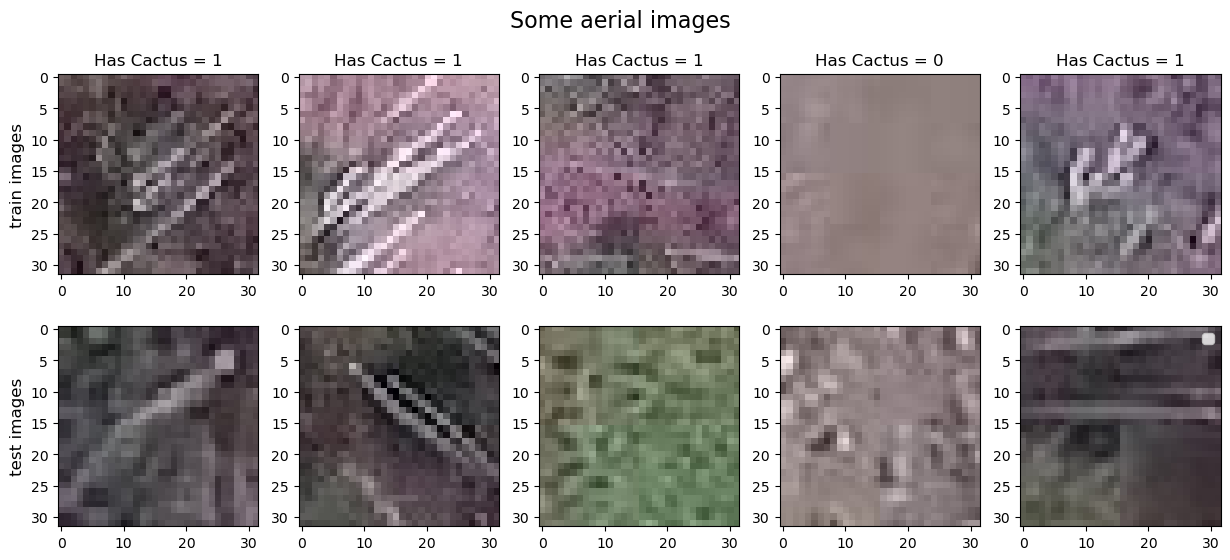

17500
17500
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 128)      512       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 30, 30, 128)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 batch_normalization_4 (Batc  (None, 13, 1

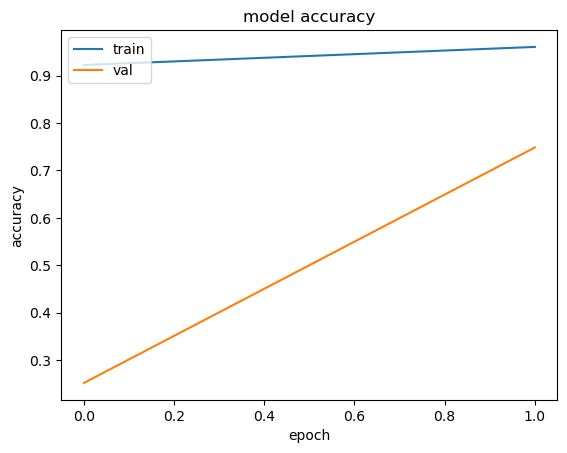

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


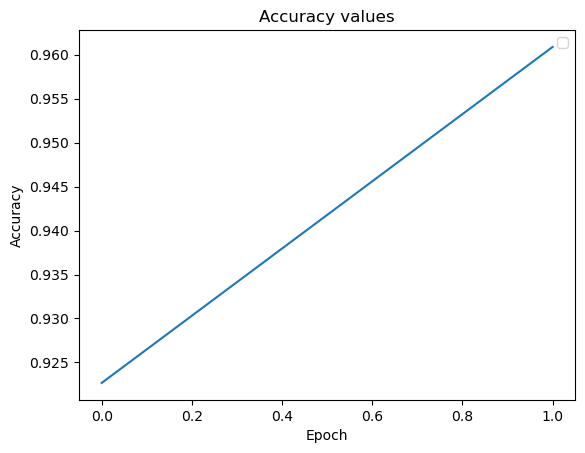

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


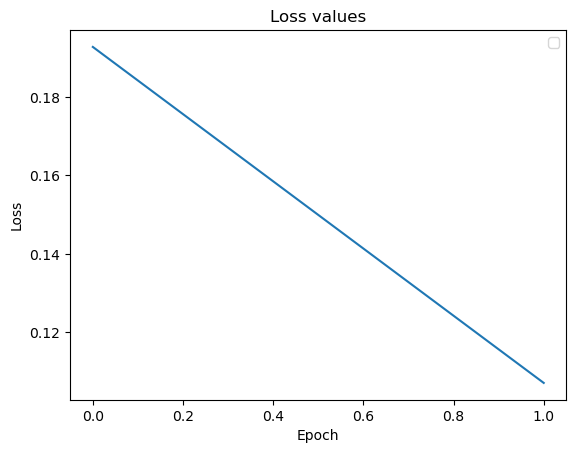

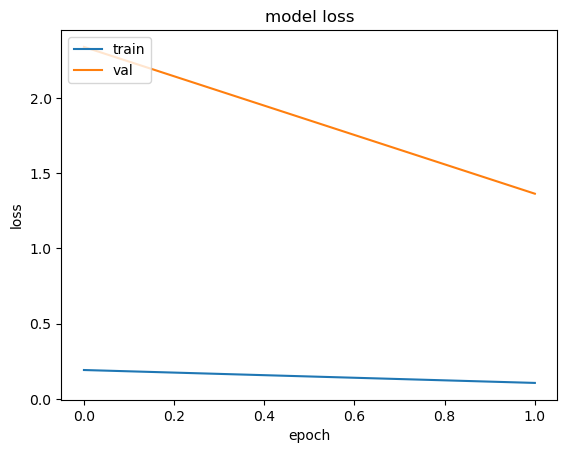

CNN/
total training time:  124.15575289726257
274/274 [==============================] - 13s 48ms/step


Exception in thread Thread-5:
Traceback (most recent call last):
  File "C:\Users\Askin\anaconda3\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "C:\Users\Askin\anaconda3\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Askin\AppData\Local\Temp\ipykernel_7688\987006027.py", line 94, in start
  File "C:\Users\Askin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 307, in confusion_matrix
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "C:\Users\Askin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 93, in _check_targets
    raise ValueError(
ValueError: Classification metrics can't handle a mix of binary and continuous targets


In [ ]:
StartPage()
